# Quantum Fourier Transform

In [2]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Background QFT info

### Introducting to Fourier Transforms

It is very common in many different problems in various fields to "transform" the problem into some other problem with a known solution. Fortunately, some of these transformations can be computed with much greater speed on a quantum computer than a classical one. The transform we will be focusing on is called the discrete Fourier transform (DFT). Classically, the DFT takes a vector of complex numbers $x_j = (x_0,\dots,x_{N-1})$ with finite length $N$ as input returing an output of the vector $y_k = (y_0,\dots,y_{N-1})$. Here, $N = 2^m$ where $m$ is the number of qubits in the system. The returned vector $y_k$ is also complex and is defined by

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

where $\omega_N^{jk} = e^{2\pi i\frac{jk}{N}}$ which gives us

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

Another way to interpret this formula is as a matrix and vector. For example, by expanding $y_k$, we can see

$$y_0 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 0} + x_1\omega^{1\cdot 0} + x_2\omega^{2\cdot 0} + \dots + x_{N-1}\omega^{(N-1)\cdot 0}) = \frac{1}{\sqrt{N}}(x_0 + x_1 + x_2 + \dots + x_{N-1})$$

$$y_1 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 1} + x_1\omega^{1\cdot 1} + x_2\omega^{2\cdot 1} + \dots + x_{N-1}\omega^{(N-1)\cdot 1}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega + x_2\omega^2 + \dots + x_{N-1}\omega^{N-1})$$

$$y_2 = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot 2} + x_1\omega^{1\cdot 2} + x_2\omega^{2\cdot 2} + \dots + x_{N-1}\omega^{(N-1)\cdot 2}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega^2 + x_2\omega^4 + \dots + x_{N-1}\omega^{2(N-1)})$$

$$\vdots$$

$$y_{N-1} = \frac{1}{\sqrt{N}}(x_0\omega^{0\cdot (N-1)} + x_1\omega^{1\cdot (N-1)} + x_2\omega^{2\cdot (N-1)} + \dots + x_{N-1}\omega^{(N-1)\cdot (N-1)}) = \frac{1}{\sqrt{N}}(x_0 + x_1\omega^{(N-1)} + x_2\omega^{2(N-1)} + \dots + x_{N-1}\omega^{(N-1)^2})$$

By simply using the coefficients of each equation, we can construct the following matrix-vector multiplication:

$$\begin{pmatrix}y_0\\ y_1\\ y_2\\ \vdots \\ y_{N-1} \end{pmatrix} = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix} \begin{pmatrix}x_0\\ x_1\\ x_2\\ \vdots \\ x_{N-1} \end{pmatrix}$$

This notation helps us clearly see how the DFT is effectively a matrix transforming a vector of amplitudes.

As it turns out, this $N\times N$ matrix is unitary, thus making it a valid quantum operation. This is the quantum Fourier transform (QFT) which is functionally the exact same transformation as the DFT, though with a bit different notation. The QFT acts on an orthonormal basis of a quantum state $|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle = x_0|0\rangle,\dots,x_{N-1}|N-1\rangle$ outputing a different quantum state $|\Phi\rangle = \sum_{k=0}^{N-1}y_k|k\rangle = y_0|0\rangle,\dots,y_{N-1}|N-1\rangle$ defined by the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

This is more commonly expressed as the map

$$|j\rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle$$

or the unitary matrix sum

$$U_{QFT} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle \langle j|$$

For example, if we have a normalized quantum state

$$|\Psi\rangle = \begin{pmatrix}x_0 \\ x_1 \\ \vdots \\ x_{N-1}\end{pmatrix} = x_0|0\rangle+\dots+x_{N-1}|N-1\rangle$$

then applying the QFT to this state will result in another normalized quantum state

$$|\Phi\rangle = \begin{pmatrix}y_0 \\ y_1 \\ \vdots \\ y_{N-1}\end{pmatrix} = y_0|0\rangle+\dots+y_{N-1}|N-1\rangle$$

where we call this the quantum Fourier transform of $|\Psi\rangle$. Therefore we can say $|\Psi\rangle$ maps to $|\Phi\rangle$ in the following way:

$$|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle \mapsto |\Phi\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}|k\rangle = \sum_{k=0}^{N-1}y_k|k\rangle$$

In simple terms, the QFT transforms between two bases: the computational basis ($Z$ basis), and the Fourier basis. Let's look at the QFT for various small values of $N$ to see what it means. By defining $\omega_N = e^{\frac{2\pi i}{N}} = \cos(\frac{2\pi}{N}) + i \sin(\frac{2\pi}{N})$ we can compute the QFT for any number of qubits:

$$\text{QFT}_N = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix}$$

$$\text{QFT}_1 = \frac{1}{\sqrt{1}}\begin{pmatrix}1 \end{pmatrix} = \frac{1}{\sqrt{1}}\begin{pmatrix}1 \end{pmatrix} = \begin{pmatrix}1 \end{pmatrix}$$

$$\text{QFT}_2 = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \omega \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & e^{\frac{2\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\frac{2\pi}{2}) + i \sin(\frac{2\pi}{2}) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\pi) + i \sin(\pi) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} = H$$

$$\text{QFT}_3 = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \omega & \omega ^2 \\ 1 & \omega ^2 & \omega ^4 \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  e^{\frac{2\pi i}{N}} &  e^{\frac{4\pi i}{N}} \\ 1 &  e^{\frac{4\pi i}{N}} &  e^{\frac{8\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  \cos(\frac{2\pi}{3}) + i \sin(\frac{2\pi}{3}) &  \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) \\ 1 & \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) &  \cos(\frac{8\pi}{3}) + i \sin(\frac{8\pi}{3}) \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \frac{-1 + i\sqrt{3}}{2} & \frac{-1 - i\sqrt{3}}{2} \\ 1 & \frac{-1 - i\sqrt{3}}{2} &  \frac{-1 + i\sqrt{3}}{2} \end{pmatrix}$$

$$\text{QFT}_8 = \frac{1}{\sqrt{8}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \omega & \omega ^2 & \omega ^3 & \omega ^4 & \omega ^5 & \omega ^6 & \omega ^7 \\ 1 & \omega ^2 & \omega ^4 & \omega ^6 & \omega ^8 & \omega ^{10} & \omega ^{12} & \omega ^{14} \\ 1 & \omega ^3 & \omega ^6 & \omega ^9 & \omega ^{12} & \omega ^{15} & \omega ^{18} & \omega ^{21} \\ 1 & \omega ^4 & \omega ^8 & \omega ^{12} & \omega ^{16} & \omega ^{20} & \omega ^{24} & \omega ^{28} \\ 1 & \omega ^5 & \omega ^{10} & \omega ^{15} & \omega ^{20} & \omega ^{25} & \omega ^{30} & \omega ^{35} \\ 1 & \omega ^6 & \omega ^{12} & \omega ^{18} & \omega ^{24} & \omega ^{30} & \omega ^{36} & \omega ^{42} \\ 1 & \omega ^7 & \omega ^{14} & \omega ^{21} & \omega ^{28} & \omega ^{35} & \omega ^{42} & \omega ^{49} \end{pmatrix} $$
$$=\frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\ 1 & \cos(\frac{2\pi}{8}) + i \sin(\frac{2\pi}{8}) & \cos(\frac{4\pi}{8}) + i \sin(\frac{4\pi}{8}) & \cos(\frac{6\pi}{8}) + i \sin(\frac{6\pi}{8}) & \cos(\frac{8\pi}{8}) + i \sin(\frac{8\pi}{8}) & \cos(\frac{10\pi}{8}) + i \sin(\frac{10\pi}{8}) & \cos(\frac{12\pi}{8}) + i \sin(\frac{12\pi}{8}) & \cos(\frac{14\pi}{8}) + i \sin(\frac{14\pi}{8}) \\ 1 & \cos(\frac{4\pi}{8}) + i \sin(\frac{4\pi}{8}) & \cos(\frac{8\pi}{8}) + i \sin(\frac{8\pi}{8}) & \cos(\frac{12\pi}{8}) + i \sin(\frac{12\pi}{8}) & \cos(\frac{16\pi}{8}) + i \sin(\frac{16\pi}{8}) & \cos(\frac{20\pi}{8}) + i \sin(\frac{20\pi}{8}) & \cos(\frac{24\pi}{8}) + i \sin(\frac{24\pi}{8}) & \cos(\frac{28\pi}{8}) + i \sin(\frac{28\pi}{8}) \\ 1 & \cos(\frac{6\pi}{8}) + i \sin(\frac{6\pi}{8}) ^3 & \cos(\frac{12\pi}{8}) + i \sin(\frac{12\pi}{8}) & \cos(\frac{18\pi}{8}) + i \sin(\frac{18\pi}{8}) & \cos(\frac{24\pi}{8}) + i \sin(\frac{24\pi}{8}) & \cos(\frac{30\pi}{8}) + i \sin(\frac{30\pi}{8}) & \cos(\frac{36\pi}{8}) + i \sin(\frac{36\pi}{8}) & \cos(\frac{42\pi}{8}) + i \sin(\frac{42\pi}{8}) \\ 1 & \cos(\frac{8\pi}{8}) + i \sin(\frac{8\pi}{8}) & \cos(\frac{16\pi}{8}) + i \sin(\frac{16\pi}{8}) & \cos(\frac{24\pi}{8}) + i \sin(\frac{24\pi}{8}) & \cos(\frac{32\pi}{8}) + i \sin(\frac{32\pi}{8}) & \cos(\frac{40\pi}{8}) + i \sin(\frac{40\pi}{8}) & \cos(\frac{48\pi}{8}) + i \sin(\frac{48\pi}{8}) & \cos(\frac{56\pi}{8}) + i \sin(\frac{56\pi}{8}) \\ 1 & \cos(\frac{10\pi}{8}) + i \sin(\frac{10\pi}{8}) & \cos(\frac{20\pi}{8}) + i \sin(\frac{20\pi}{8}) & \cos(\frac{30\pi}{8}) + i \sin(\frac{30\pi}{8}) & \cos(\frac{40\pi}{8}) + i \sin(\frac{40\pi}{8}) & \cos(\frac{50\pi}{8}) + i \sin(\frac{50\pi}{8}) & \cos(\frac{60\pi}{8}) + i \sin(\frac{60\pi}{8}) & \cos(\frac{70\pi}{8}) + i \sin(\frac{70\pi}{8}) \\ 1 & \cos(\frac{12\pi}{8}) + i \sin(\frac{12\pi}{8})& \cos(\frac{24\pi}{8}) + i \sin(\frac{24\pi}{8}) & \cos(\frac{36\pi}{8}) + i \sin(\frac{36\pi}{8}) & \cos(\frac{48\pi}{8}) + i \sin(\frac{48\pi}{8}) & \cos(\frac{60\pi}{8}) + i \sin(\frac{60\pi}{8}) & \cos(\frac{72\pi}{8}) + i \sin(\frac{72\pi}{8}) & \cos(\frac{84\pi}{8}) + i \sin(\frac{84\pi}{8}) \\ 1 & \cos(\frac{14\pi}{8}) + i \sin(\frac{14\pi}{8})& \cos(\frac{28\pi}{8}) + i \sin(\frac{28\pi}{8}) & \cos(\frac{42\pi}{8}) + i \sin(\frac{42\pi}{8}) & \cos(\frac{56\pi}{8}) + i \sin(\frac{56\pi}{8}) & \cos(\frac{70\pi}{8}) + i \sin(\frac{70\pi}{8}) & \cos(\frac{84\pi}{8}) + i \sin(\frac{84\pi}{8}) & \cos(\frac{98\pi}{8}) + i \sin(\frac{98\pi}{8}) \end{pmatrix}$$

$$ = \frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \frac{1+i}{\sqrt{2}} & i & \frac{-1+i}{\sqrt{2}} & -1 & \frac{-1-i}{\sqrt{2}} & -i & \frac{1-i}{\sqrt{2}} \\ 1 & i & -1 & -i & 1 & i & -1 & -i \\ 1 & \frac{-1+i}{\sqrt{2}} & -i & \frac{1+i}{\sqrt{2}} & -1 & \frac{1-i}{\sqrt{2}} & i & \frac{-1-i}{\sqrt{2}} \\ 1 & -1 & 1 & -1 & 1 & -1 & 1 & -1 \\ 1 & \frac{-1-i}{\sqrt{2}} & i & \frac{1-i}{\sqrt{2}} & -1 & \frac{1+i}{\sqrt{2}} & -i & \frac{-1+i}{\sqrt{2}} \\ 1 & -i & -1 & i & 1 & -i & -1 & i \\ 1 & \frac{1-i}{\sqrt{2}} & -i & \frac{-1-i}{\sqrt{2}} & -1 & \frac{-1+i}{\sqrt{2}} & i & \frac{1+i}{\sqrt{2}} \end{pmatrix} $$

Looking at $\text{QFT}_2$ which is the transform for $m=1$ qubits because $N=2^m$, we see that this is exactly the Hadamard gate $H$. As we know, this gate transforms the $Z$-basis states $|0\rangle$ and $|1\rangle$ to the Fourier-basis states $|+\rangle$ and $|-\rangle$ respectively. Similarly, every multi-qubit state in the computational basis has a corresponding Fourier basis state like this. So like we mentioned before, the QFT is just a transformation between these two bases. States in the Fourier basis are often denoted with a tilde (~). For example, the QFT on the state $|x\rangle$ is notated as 

$$\text{QFT}|x\rangle = |\tilde{x}\rangle$$

What about $\text{QFT}_N$ for large values of N? In an $m$-qubit system where $N=2^m$, we can derive the QFT acting on a state $|x\rangle = |x_1\dots x_m\rangle$ where $x_1$ is our most significant bit. Starting with our $\text{QFT}_N$ summation, we proceed with the following steps:

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi i\frac{xy}{2^m}}|y\rangle$$

We can rewrite this equation using fractional binary notation where $y = y_1y_2...y_m$ and $\frac{y}{2^m} = \sum_{k=1}^m\frac{y_k}{2^k}$ which gives

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi ix\left(\sum_{k=1}^m\frac{y_k}{2^k}\right)}|y_1\dots y_m\rangle$$

We can then expand the sum in our exponential to a product of exponentials leaving us with

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\prod_{k=1}^me^{2\pi i\frac{xy_k}{2^k}}|y_1\dots y_m\rangle$$

By rearranging our sum and products and expanding $\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\dots\sum_{y_m=0}^{1}$ we are able to obtain

$$\frac{1}{\sqrt{N}}\bigotimes_{k=1}^{m}\left(|0\rangle +e^{\frac{2\pi ix}{2^k}}|1\rangle \right)$$

which when expanded, finally leaves us with

$$\frac{1}{\sqrt{N}}\left(|0\rangle +e^{\frac{2\pi ix}{2}}|1\rangle \right)\otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^2}}|1\rangle \right)\otimes \dots \otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^{m-1}}}|1\rangle \right)\otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^m}}|1\rangle \right)$$

In order to really understand what is happening between these two bases, we can look at how different states in each basis is represented on the Bloch sphere. The .gif's in $\text{Fig. }1$ and $\text{Fig. }2$ are taken from the Qiskit notebook on the QFT and show very clearly how a number in the computational and Fourier bases are represented with 4 qubits. In the computational basis, we can see that the leftmost qubit has the highest "flipping" frequency where it flips with every step up. The second qubit, qubit $1$, flips twice as frequently as qubit $0$, and the next twice as much as that and the pattern continues. So any subsequent qubit in the computational basis will have double the frequency as the qubit before it and so on. 

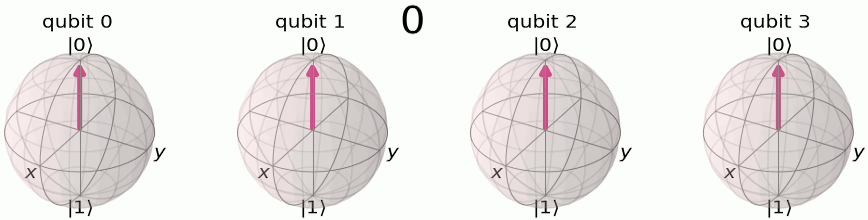

$$\textbf{Fig. }1:\text{ Counting in Computational Basis}$$

Looking at how we count in the Fourier basis in $\text{Fig. }2$, we can see that each number is instead represented as a rotation around the $Z$-axis. Starting with the $|\tilde{0}\rangle$ state, every qubit is in the $|+\rangle$ state. Each number in the Fourier basis tells us exactly how many turns the leftmost qubit makes around the $Z$-axis by the formula $\frac{a}{2^m}$ where $a$ is the number we want to store and $m$ is again the number of qubits. For example, to encode the state $|\tilde{7}\rangle$ on $4$ qubits as shown in $\text{Fig. }2$, we simply do $\frac{a}{2^m} = \frac{7}{2^4} = \frac{7}{16}$ full turns around the $Z$-axis which is equivalent to $2\pi\times\frac{7}{16} = \frac{7\pi}{8}$ because $2\pi \equiv \text{One Full Rotation}$. The next qubit is rotated double as much as the previous $(2\times \frac{7\pi}{8} = \frac{7\pi}{4})$ and so on for all subsequent qubits. In the Fourier basis, the leftmost qubit now has the lowest frequency whereas in the computational basis the leftmost qubit had the highest.

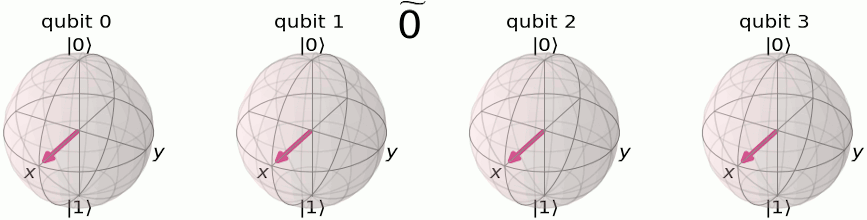

$$\textbf{Fig. }2:\text{ Counting in Fourier Basis}$$

In order to implement a quantum circuit of the QFT, we need two different gates. The first is the $H$-gate which we already know acts on a single qubit state $|x_k\rangle$ in the following way

$$H|x_k\rangle = \left(|0\rangle + e^{\frac{2\pi i}{2}x_k}|1\rangle \right)$$

The second gate we need is a controlled phase gate making use of two qubits: a control qubit and a target qubit. This gate is composed of the indentiy gate and a phase gate. We know a single qubit phase operation is represented by the matrix $P_k = \begin{pmatrix}1 & 0 \\ 0 & e^{\frac{2\pi i}{2^k}}\end{pmatrix}$ and a controlled operation as the block diagonal matrix $C = \begin{bmatrix}I & 0 \\ 0 & \text{Gate} \end{bmatrix}$ where $\text{Gate}$ is the operation applied to the target qubit. So the controlled version of our phase gate is written as

$$CP_k = \begin{bmatrix}I & 0 \\ 0 & P_k \end{bmatrix} = \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{\frac{2\pi i}{2^k}}\end{pmatrix}$$

Therefore, we can see that the $CP_k$ gate acts on the $|0\rangle$ an $|1\rangle$ states of a two-qubit state $|x_jx_l\rangle$ where the first qubit is the control and the second the target in the following ways:

$$CP_k|0x_l\rangle = |0x_l\rangle$$

$$CP_k|1x_l\rangle = e^{\frac{2\pi i}{2^k}x_k}|1x_l\rangle$$

fourier summation derivation

Rotation gate

1-qubit qft (walk through circuit math)

## Algorithm

$R(\theta) = \begin{pmatrix}1&0\\0&e^{i\theta}\end{pmatrix}$

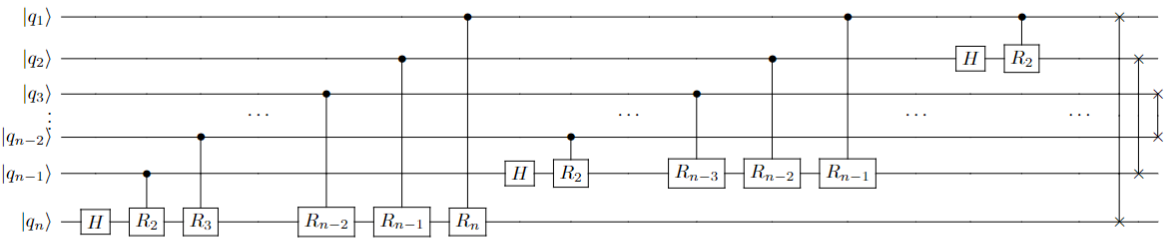

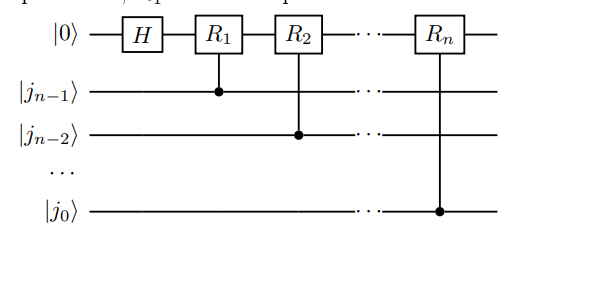

$$\text{Fig. }3.1:\text{ QFT Circuit }$$

### Proof
$$ U_{FT}|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{i2\pi \frac{kj}{N}}|k\rangle$$
$$ U_{FT}^\dagger|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{-i2\pi \frac{kj}{N}}|k\rangle$$
Where k and j are binary numbers
$k = (k_{n-1} \cdots k_0.), j = (j_{n-1} \cdots j_0.)$

$$\frac{kj}{N} = k_0\frac{j}{2^n} +k_1\frac{j}{2^{n-1}} + \cdots + k_n\frac{j}{2} = k_0(j_n.j_{n-1} \cdots j_0) +k_1(j_nj_{n-1}.j_{n-2} \cdots j_0) + \cdots + k_n(j_nj_{n-1}j_{n-2}.j_{n-3} \cdots j_0)$$ 
show general circuit as function

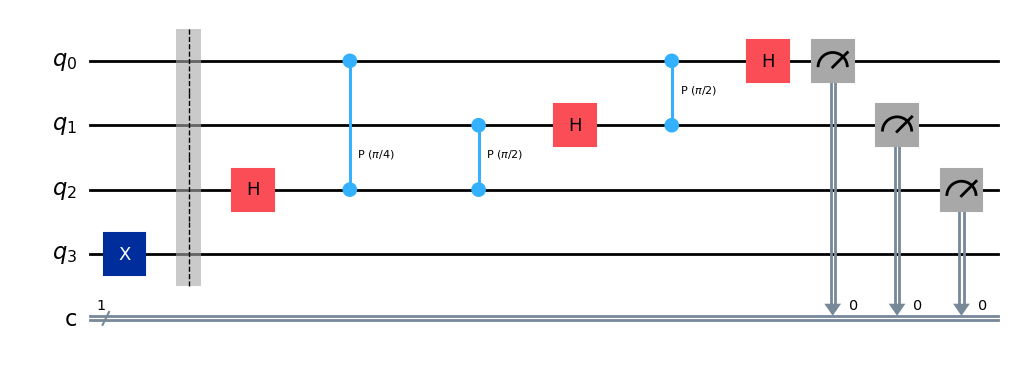

In [24]:
qc = QuantumCircuit(4,1)
qc.x(3)
qc.barrier()
qc.h(2)
qc.cp(pi/4,0,2)
qc.cp(pi/2,1,2)
qc.h(1)
qc.cp(pi/2,0,1)
qc.h(0)
#qc.swap(0,2)
qc.measure(0,0)
qc.measure(1,0)
qc.measure(2,0)
qc.draw('mpl')

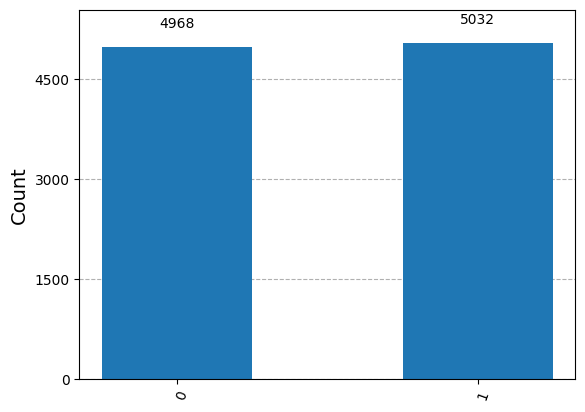

In [22]:
backend = BasicSimulator()

num_of_shots = 10000

result = backend.run(qc, shots=num_of_shots).result()   
counts = result.get_counts()                    
plot_histogram(counts)

### Verfication